In [46]:
from datasets import load_dataset

dataset = load_dataset("csv", data_files="IMDB_1.csv")
dataset

DatasetDict({
    train: Dataset({
        features: ['review_es', 'sentiment'],
        num_rows: 250
    })
})

In [47]:
df = dataset["train"].to_pandas()
df["sentiment"].unique()

array(['positive', 'negative'], dtype=object)

In [48]:
df

,review_es,sentiment
0,Uno de los otros críticos ha mencionado que de...,positive
1,Una pequeña pequeña producción.La técnica de f...,positive
2,Pensé que esta era una manera maravillosa de p...,positive
3,"Básicamente, hay una familia donde un niño peq...",negative
4,"El ""amor en el tiempo"" de Petter Mattei es una...",positive
...,...,...
245,He visto esta película al menos 100 veces y to...,positive
246,Este espectáculo no tiene absolutamente ningún...,negative
247,¡Esta película fue tan mala que fue divertido!...,negative
248,"Meryl Streep es un genio.Bueno, al menos como ...",positive


In [49]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

In [50]:
labels = encoder.fit_transform(dataset["train"]["sentiment"])

In [51]:
dataset["train"] = dataset["train"].add_column("label", labels)
dataset["train"] = dataset["train"].remove_columns("sentiment")
dataset = dataset.rename_column("review_es", "text")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 250
    })
})

In [52]:
dataset = dataset['train'].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50
    })
})

In [53]:
dataset["train"].features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [59]:
from transformers import AutoTokenizer, DataCollatorWithPadding

checkpoint = "google-bert/bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [60]:
def tokenize(sample):
    return tokenizer(sample["text"], truncation=True)

In [61]:
tokenized_dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [62]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [63]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50
    })
})

In [66]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=8,  
    metric_for_best_model="f1",
    num_train_epochs=3,
)

In [67]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

model.safetensors:  44%|####4     | 315M/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [68]:
import evaluate
import numpy as np

metric = evaluate.load("f1")

In [69]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

In [81]:

from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

In [83]:
import torch

In [84]:
torch.cuda.is_available()

False

In [85]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [86]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [87]:
trainer.train()

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.865064799785614, 'eval_f1': 0.7413525410164066, 'eval_runtime': 5.4119, 'eval_samples_per_second': 9.239, 'eval_steps_per_second': 1.293, 'epoch': 1.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.9870959520339966, 'eval_f1': 0.7971479500891266, 'eval_runtime': 5.3921, 'eval_samples_per_second': 9.273, 'eval_steps_per_second': 1.298, 'epoch': 2.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.1022051572799683, 'eval_f1': 0.8158480325644504, 'eval_runtime': 5.4962, 'eval_samples_per_second': 9.097, 'eval_steps_per_second': 1.274, 'epoch': 3.0}
{'train_runtime': 315.7491, 'train_samples_per_second': 1.9, 'train_steps_per_second': 0.238, 'train_loss': 0.1535552469889323, 'epoch': 3.0}


TrainOutput(global_step=75, training_loss=0.1535552469889323, metrics={'train_runtime': 315.7491, 'train_samples_per_second': 1.9, 'train_steps_per_second': 0.238, 'total_flos': 151181967965760.0, 'train_loss': 0.1535552469889323, 'epoch': 3.0})

In [88]:
trainer.evaluate()

  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.1022051572799683,
 'eval_f1': 0.8158480325644504,
 'eval_runtime': 5.2572,
 'eval_samples_per_second': 9.511,
 'eval_steps_per_second': 1.332,
 'epoch': 3.0}

In [89]:
predictions = trainer.predict(tokenized_dataset["test"])

  0%|          | 0/7 [00:00<?, ?it/s]

In [90]:
predictions

PredictionOutput(predictions=array([[ 2.8906636 , -4.0325127 ],
       [ 0.2630383 , -0.633734  ],
       [ 2.9455812 , -4.006502  ],
       [-2.8390574 ,  3.3941827 ],
       [-3.1036813 ,  3.7513757 ],
       [ 0.52758306, -1.0816823 ],
       [ 2.1971543 , -2.8424597 ],
       [-2.9905562 ,  3.6532974 ],
       [-1.9516493 ,  2.1707106 ],
       [-2.5551805 ,  3.0150852 ],
       [ 2.9821525 , -4.057315  ],
       [ 2.681645  , -3.6498747 ],
       [ 2.8369288 , -3.9564025 ],
       [ 2.9431205 , -4.0480833 ],
       [-3.0808487 ,  3.770484  ],
       [ 1.9924453 , -2.736612  ],
       [ 2.9514914 , -4.0984554 ],
       [ 2.915102  , -4.0130806 ],
       [-2.9778242 ,  3.5950258 ],
       [ 2.6004348 , -3.5614042 ],
       [-3.019335  ,  3.6540306 ],
       [ 2.9167645 , -4.0376935 ],
       [-3.1125078 ,  3.7680988 ],
       [ 2.8654017 , -4.0422897 ],
       [ 2.483306  , -3.4946463 ],
       [ 2.9710302 , -4.0953703 ],
       [ 2.9544396 , -3.9683065 ],
       [-2.971387  ,  3.59

In [91]:
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

In [92]:
preds

array([0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0], dtype=int64)

In [93]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [94]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87        32
           1       0.80      0.67      0.73        18

    accuracy                           0.82        50
   macro avg       0.81      0.79      0.80        50
weighted avg       0.82      0.82      0.82        50



Text(0.5, 1.0, 'Confusion Matrix')

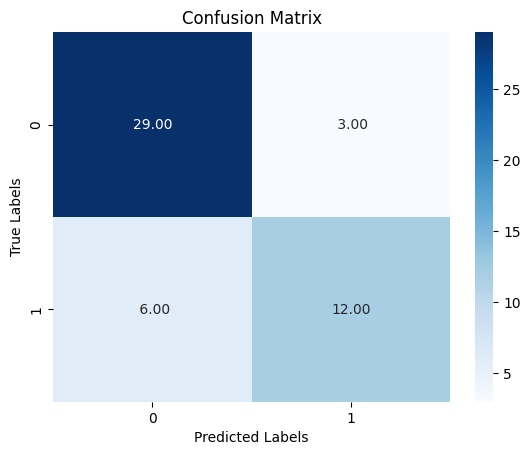

In [95]:
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

In [96]:
encoder.inverse_transform([0, 1])

array(['negative', 'positive'], dtype='<U8')